In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [261]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [435]:
dim = 50

In [436]:
mean0 = torch.tensor(np.random.randint(low=0, high=1, size=dim), dtype=torch.float64)

In [486]:
A = np.random.normal(0, 1, (dim, dim))
A = A @ A.T

_, U = np.linalg.eigh(A)

eig_vals = np.linspace(1, 100, dim)
A = U @ np.diag(eig_vals) @ U.T
A_torch = torch.tensor(A, dtype=torch.float64)

C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [487]:
potential = lambda x: torch.linalg.norm((x - mean0[None, :]) @ A_torch, axis=-1)

In [488]:
num_particles = 10
particles = np.random.normal(0, 5, (num_particles, dim))
particles = torch.tensor(particles, dtype=torch.float64, requires_grad=True)

counter = 2

In [489]:
h = 0.01
beta = 10

In [490]:
C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
eig_vals, U = torch.linalg.eigh(C1)

In [515]:
num_iters = 5000
counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
for i in range(num_iters):
    vals = potential(particles)
    vals.sum().backward()
    beta = 10 * np.sin(i / 1000) ** 2 + 1
    with torch.no_grad():
        C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_vals = potential(rounded_particles)
        history[i] = vals.min()
        rounded_history[i] = rounded_vals.min()
    
        C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
    
    counter += 1
    particles.grad.zero_()

In [516]:
rounded_history.min()

tensor(0., dtype=torch.float64)

In [517]:
history.min()

tensor(45.5335, dtype=torch.float64)

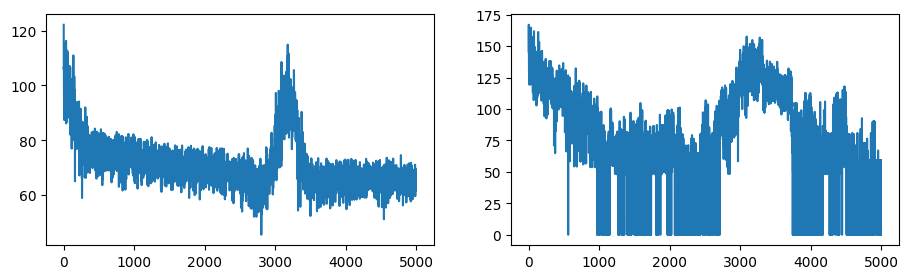

In [518]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [38]:
is_valid = lambda x: True

In [39]:
num_iters = 10_000

# particle = np.random.randint(low=0, high=5, size=dim)
particle = np.ones(dim) * -5
particle = torch.tensor(particle, dtype=torch.float64, requires_grad=True)
new_particle = particle.clone().detach().requires_grad_(True)

D_temp = torch.ones(dim, dtype=torch.float64)
# D_temp = torch.eye(dim, dtype=torch.float64)
C = torch.eye(dim, dtype=torch.float64)
sqrt_C = torch.eye(dim, dtype=torch.float64)
counter = 1
alpha = 0.1

In [40]:
sigma = 1
w = np.zeros(2 * dim)
h = 0.1

In [57]:
# D_temp = torch.ones(dim, dtype=torch.float64)
best_val = np.inf
best_particle = None
num_invalid_moves = 0

history = torch.zeros(num_iters, dim)
history_val = torch.zeros(num_iters)
for i in range(num_iters):
    val = potential(particle)
    history_val[i] = val
    
    if val < best_val:
        best_val = val
        best_particle = particle.detach().clone()
    
    val.backward()
    
    #a = 1 * np.cos(np.pi * i / 1000) ** 2 + 0.0001
    a = 0.1
    # d = -C @ particle.grad + np.sqrt(2) * sqrt_C @ torch.randn_like(particle) * a
    d = -particle.grad * (abs(torch.randn_like(particle)))
    k = torch.argmax(abs(d))
        
    with torch.no_grad():
        if abs(d[k]) > 1e-6:
            particle[k] += 1 if d[k] > 0 else -1
        D_temp = (1 - alpha) * D_temp + alpha * particle.grad ** 2
        
        # eig_vals, U = torch.linalg.eigh(D_temp + 1e-5 * torch.eye(dim))
        C = torch.diag(1 / torch.sqrt(D_temp))
        # sqrt_C = U @ torch.diag(1 / torch.sqrt(eig_vals)) @ U.T

        if not is_valid(particle):
            num_invalid_moves += 1
            particle[k] += -1 if d[k] > 0 else 1
        history[i] = particle
            
    counter += 1
    
    if i % 1000 == 0:
        print(f"Iteration {i}: {best_val.detach().numpy()}")
    
    particle.grad.zero_()
print(f"Iteration {i}: {best_val.detach().numpy()}")
history = history.numpy()
history_val = history_val.detach().numpy()

Iteration 0: 135.06984352121697
Iteration 1000: 115.43489465351415
Iteration 2000: 115.43489465351415
Iteration 3000: 115.43489465351415
Iteration 4000: 114.41302186290903
Iteration 5000: 114.41302186290903
Iteration 6000: 0.0
Iteration 7000: 0.0
Iteration 8000: 0.0
Iteration 9000: 0.0
Iteration 9999: 0.0


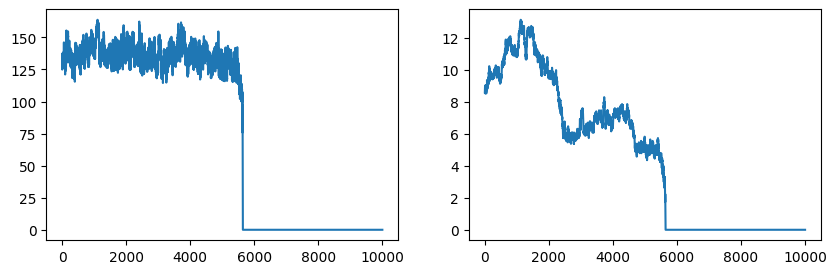

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(history_val)
axs[1].plot(np.linalg.norm(history - mean0.detach().numpy(), axis=1))

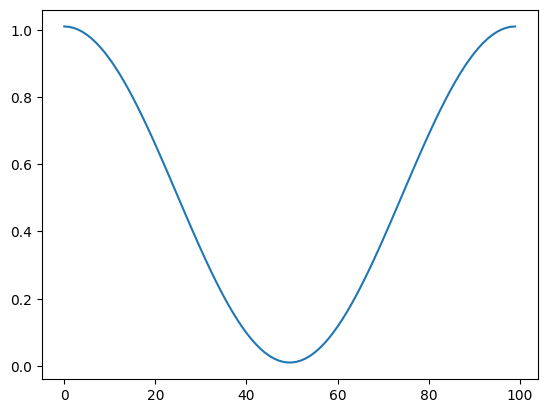

In [27]:
plt.plot(np.cos(np.pi * np.linspace(0, 1, 100)) ** 2 + 0.01)

In [813]:
dim = 100

In [814]:
mean0 = torch.tensor(np.random.randint(low=0, high=5, size=dim), dtype=torch.float64)

In [821]:
A = np.random.normal(0, 1, (dim, dim))
A = A @ A.T

_, U = np.linalg.eigh(A)

eig_vals = np.linspace(1, 4, dim)
A = U @ np.diag(eig_vals) @ U.T
# A = np.diag(eig_vals)
A_torch = torch.tensor(A, dtype=torch.float64)

In [822]:
potential = lambda x: torch.linalg.norm(A_torch @ (x - mean0))

In [823]:
is_valid = lambda x: True

In [904]:
num_iters = 10_000

particle = np.ones(dim) * 5
particle = torch.tensor(particle, dtype=torch.float64, requires_grad=True)
new_particle = particle.clone().detach().requires_grad_(True)

D_temp = torch.ones(dim, dtype=torch.float64)
C = torch.eye(dim, dtype=torch.float64)
sqrt_C = torch.eye(dim, dtype=torch.float64)
counter = 1
alpha = 0.1
w = np.ones(dim)

In [931]:
best_val = np.inf
best_particle = None
num_invalid_moves = 0

history = torch.zeros(num_iters, dim)
history_val = torch.zeros(num_iters)
for i in range(num_iters):
    val = potential(particle)
    history_val[i] = val
    
    if val < best_val:
        best_val = val
        best_particle = particle.detach().clone()
    
    val.backward()
    
    d = -particle.grad
    k = np.random.choice(range(dim), p=w/w.sum())
        
    with torch.no_grad():
        if abs(d[k]) > 1e-6:
            particle[k] += 1 if d[k] > 0 else -1
        D_temp = (1 - alpha) * D_temp + alpha * particle.grad ** 2
        # w = 1 / D_temp.detach().numpy()
        
        if not is_valid(particle):
            num_invalid_moves += 1
            particle[k] += -1 if d[k] > 0 else 1
        history[i] = particle
            
    counter += 1
    
    if i % 1000 == 0:
        print(f"Iteration {i}: {best_val.detach().numpy()}")
    
    particle.grad.zero_()
print(f"Iteration {i}: {best_val.detach().numpy()}")
history = history.numpy()
history_val = history_val.detach().numpy()

Iteration 0: 38.86234634420692
Iteration 1000: 30.16486082417101
Iteration 2000: 30.12748752569058
Iteration 3000: 30.12748752569058
Iteration 4000: 30.12748752569058
Iteration 5000: 30.12748752569058
Iteration 6000: 30.12748752569058
Iteration 7000: 30.12748752569058
Iteration 8000: 30.12748752569058
Iteration 9000: 30.12748752569058
Iteration 9999: 30.12748752569058


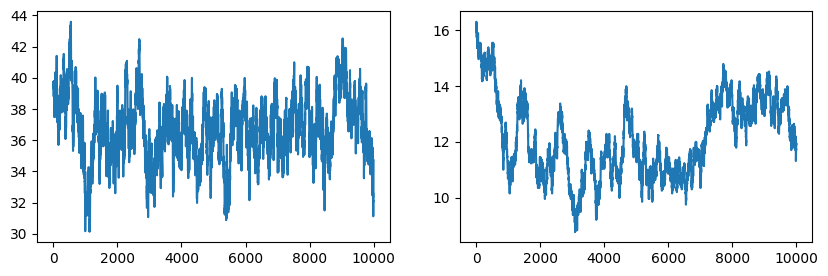

In [932]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(history_val)
axs[1].plot(np.linalg.norm(history - mean0.detach().numpy(), axis=1))